In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Read and Transform Data

From the challenge description:

> We selected ~200 patients who have been enrolled in the program for 3 to 11 months and
included all their blood pressure and blood glucose readings and organized by time stamp.
>
> I attached the de-identified dataset:
> * The first dataset &quot;Health_Sample dataset_SBP by month.xlsx&quot; contains all monthly
average Systolic BP readings of each patient with a timestamp.
> * The second dataset “iHealth Time Series - v1” contains all the original data.

I have renamed these files respectively `SBP_by_month.xlsx` and `time_series.xlsx`.

## Read Files and Rename Columns

In [3]:
sbp = pd.read_excel('data/SBP_by_month.xlsx')
# drop unnamed column
sbp.pop('Unnamed: 0')
print(sbp.shape)
print(sbp.dtypes)

ts = pd.read_excel('data/time_series.xlsx')
print(ts.shape)
print(sbp.dtypes)

sbp.rename({
    'memberId': 'member_id', 
    'systolic_mmHg': 'systolic'
}, axis=1, inplace=True)

ts.rename({
    'memberId': 'member_id', 
    'Enrolled Tasks': 'tasks', 
    'Is Still Enrolled': 'enrolled', 
    'systolic BP_mmHg': 'systolic', 
    'diastolic BP_mmHg': 'diastolic',
    'datetime_utc': 'utc',
    'Gender': 'gender',
    'timezone_local': 'tz',
    'took_medication': 'took_med',
    'datetime_local': 'dt_local'
}, axis=1, inplace=True)

(1203, 3)
memberId                 object
month            datetime64[ns]
systolic_mmHg           float64
dtype: object
(33125, 21)
memberId                 object
month            datetime64[ns]
systolic_mmHg           float64
dtype: object


## Drop Null Measurements

Drop 58 null measurements

In [4]:
ts = ts.loc[ts.measurement_id.notnull()]

## Create `members` Dataframe

In [5]:
assert set(sbp.member_id).issubset(set(ts.member_id))

member_cols = ['member_id', 'gender', 'age_range']

members = ts[member_cols].drop_duplicates()
assert members.member_id.value_counts().max() == 1

ts.drop(member_cols[1:], axis=1, inplace=True)

members.head()

,member_id,gender,age_range
1,62a260c03b64e85e96af1d20,M,45-49
367,62a260c43b64e85e96af1d28,F,60-64
444,62a260c43b64e85e96af1d29,F,50-54
480,62a260c53b64e85e96af1d2a,F,50-54
504,62a260c63b64e85e96af1d2c,M,35-39


## Drop Unnecessary Columns

In [6]:
ts.drop([
    'tz',
    'utc', 
    'dt_local', 
    'tasks', 
    'enrolled'
], axis=1, inplace=True)

## Check dtypes

In [7]:
sbp.dtypes

member_id            object
month        datetime64[ns]
systolic            float64
dtype: object

In [8]:
ts.dtypes

member_id                   object
date_local          datetime64[ns]
type                        object
took_med                   float64
measurement_id              object
arrhythmic                 float64
systolic                   float64
diastolic                  float64
heart_rate_bp              float64
bg_mmol                    float64
meal_type                   object
before_meal                float64
body_weight                float64
weight_change_kg           float64
dtype: object

In [9]:
members.dtypes

member_id    object
gender       object
age_range    object
dtype: object

## Split `ts` Into 3 Dataframes

The data are split into three measurement types, so lets split measurements into separate dataframes per type. This will simplify things, since many values are null for columns unrelated to the measurement.

In [10]:
def construct_df(type, ordercols):
    df = ts.loc[ts.type == type]
    pct_null = df.isnull().mean()
    dropcols = pct_null[pct_null == 1].index.values
    df.drop(dropcols, axis=1, inplace=True)
    df = df[ordercols]
    return df.drop_duplicates()
    
ordercols = ['member_id', 'measurement_id', 'date_local', 'took_med', 'arrhythmic', 'diastolic', 'systolic']
bp = construct_df('BP', ordercols)

ordercols = ['member_id', 'measurement_id', 'date_local', 'took_med', 'before_meal', 'meal_type', 'bg_mmol']
bg = construct_df('BG', ordercols)

ordercols = ['member_id', 'measurement_id', 'date_local', 'weight_change_kg']
hs = construct_df('HS', ordercols)

## Top-Level Metrics

## Blood Pressure Control

According to the provided chart, “Hypertension Stage 2” and “Hypertensive Crisis” are considered “Uncontrolled”. Since only systolic blood pressure is provided, we will only use this. In theory, this could underestimate the actual number of uncontrolled patients, since it doesn't include diastolic. However, the correlation between these metrics is perfect.

In [11]:
sbp['controlled'] = sbp['systolic'] < 140

In [12]:
month = bp.date_local.dt.to_period('m').dt.to_timestamp().rename('month')
my_avg = bp.groupby([month, 'member_id'])[['systolic', 'diastolic']].mean().round(2)

my_avg['uncontrolled_systolic'] = my_avg.systolic >= 140
my_avg['uncontrolled_both'] = (my_avg.systolic >= 140) | (my_avg.diastolic >= 120)

my_avg.corr()

,systolic,diastolic,uncontrolled_systolic,uncontrolled_both
systolic,1.000000,0.531359,0.806706,0.806706
diastolic,0.531359,1.000000,0.422070,0.422070
uncontrolled_systolic,0.806706,0.422070,1.000000,1.000000
uncontrolled_both,0.806706,0.422070,1.000000,1.000000


Observe that the correlation between the uncontrolled metrics using only systolic versus both systsolic and diastolic is perfect.

## Months

Reindex months to count time passed since the member entered the program.

In [13]:
first_month = sbp.groupby('member_id')['month'].min().rename('first_month')
members = members.join(first_month, on='member_id')
sbp = sbp.join(first_month, on='member_id')
sbp['months'] = sbp['month'].dt.to_period('m').astype(int) - sbp['first_month'].dt.to_period('m').astype(int)
print(sbp.shape)

(1203, 6)


## Controlled at Baseline

Whether the member was controlled during their first month, considered baseline.

In [14]:
# # Whether the member was controlled at baseline
tmp = sbp.loc[sbp.months == 0, ['member_id', 'controlled']]
tmp.rename({'controlled': 'ctrl_bl'}, axis=1, inplace=True)
tmp.set_index('member_id', inplace=True)
sbp = sbp.join(tmp, on='member_id')
print(sbp.shape)

(1203, 7)


# Data Quality

## Missing Values

After cleaning and splitting the data above, there are no remaining missing values.

In [15]:
for df in [sbp, bp, bg, hs]:
    assert df.isnull().sum().max() == 0

### Patient Sampling

Of the 283 members with measurements in the full dataset, 246 of them were sampled for the SBP monthly dataset.

In [16]:
print(sbp.member_id.nunique())
print(ts.member_id.nunique())

246
283


### Verify Monthly Avg
I'm not able to exactly replicate the calculated monthly average in the SBP dataset, but it is very close (within ~4 points) for the vast majority of members.

In [17]:
month = bp.date_local.dt.to_period('m').dt.to_timestamp().rename('month')
my_avg = bp.groupby([month, 'member_id'])['systolic'].mean().round(2).to_frame()
combined = sbp.join(my_avg, on=['month', 'member_id'], lsuffix='_sbp')
combined.head()

(combined.systolic_sbp - combined.systolic).describe(percentiles=[0.01, 0.99])

count    1203.000000
mean        0.018263
std         1.526563
min       -23.840000
1%         -3.978200
50%         0.000000
99%         4.769400
max        10.800000
dtype: float64

# Questions

## Visualize All Members

> Can you draw a figure that visualizes the SBP (systolic blood pressure) change over the months
for each patient based on the first data file? In this way, we can have an initial observation of
different blood pressure risk change patterns over time.

From the charts below, we can see that members' blood pressure generally falls over the course of their participation in the program, with a slight increase at month 10. However, not many members make it to month 10.

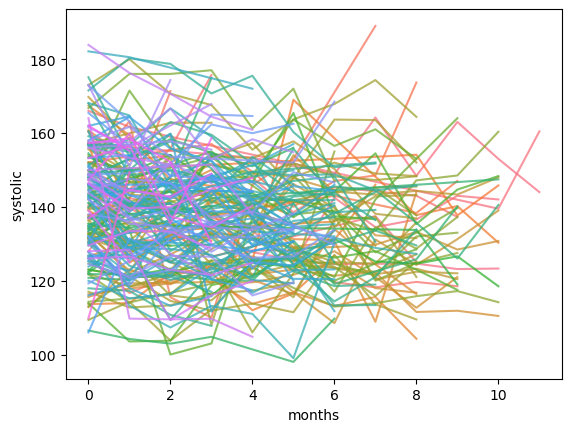

In [18]:
sns.lineplot(data=sbp, x="months", y="systolic", hue="member_id", legend=False, alpha=0.75);

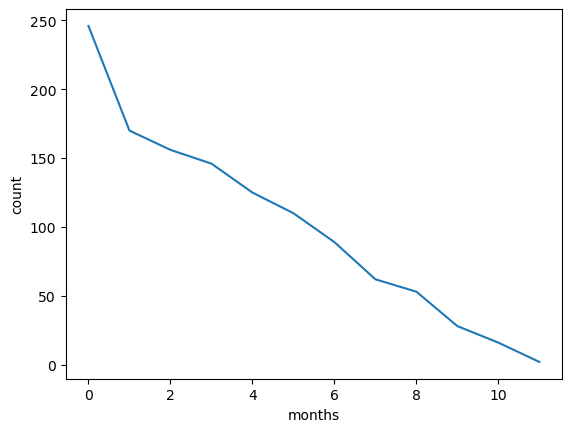

In [19]:
sns.lineplot(sbp.months.value_counts());

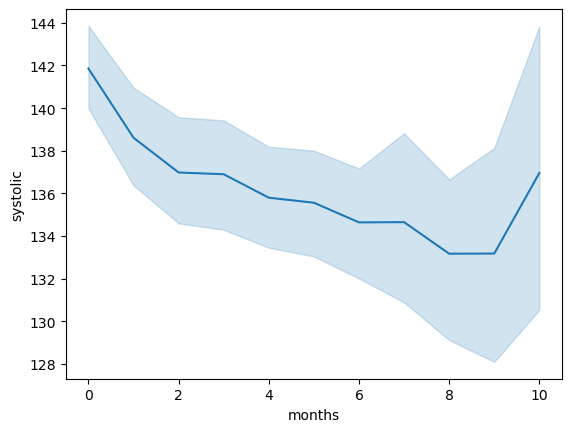

In [20]:
mask = sbp.months < 11
sns.lineplot(data=sbp[mask], x="months", y="systolic", legend=False);

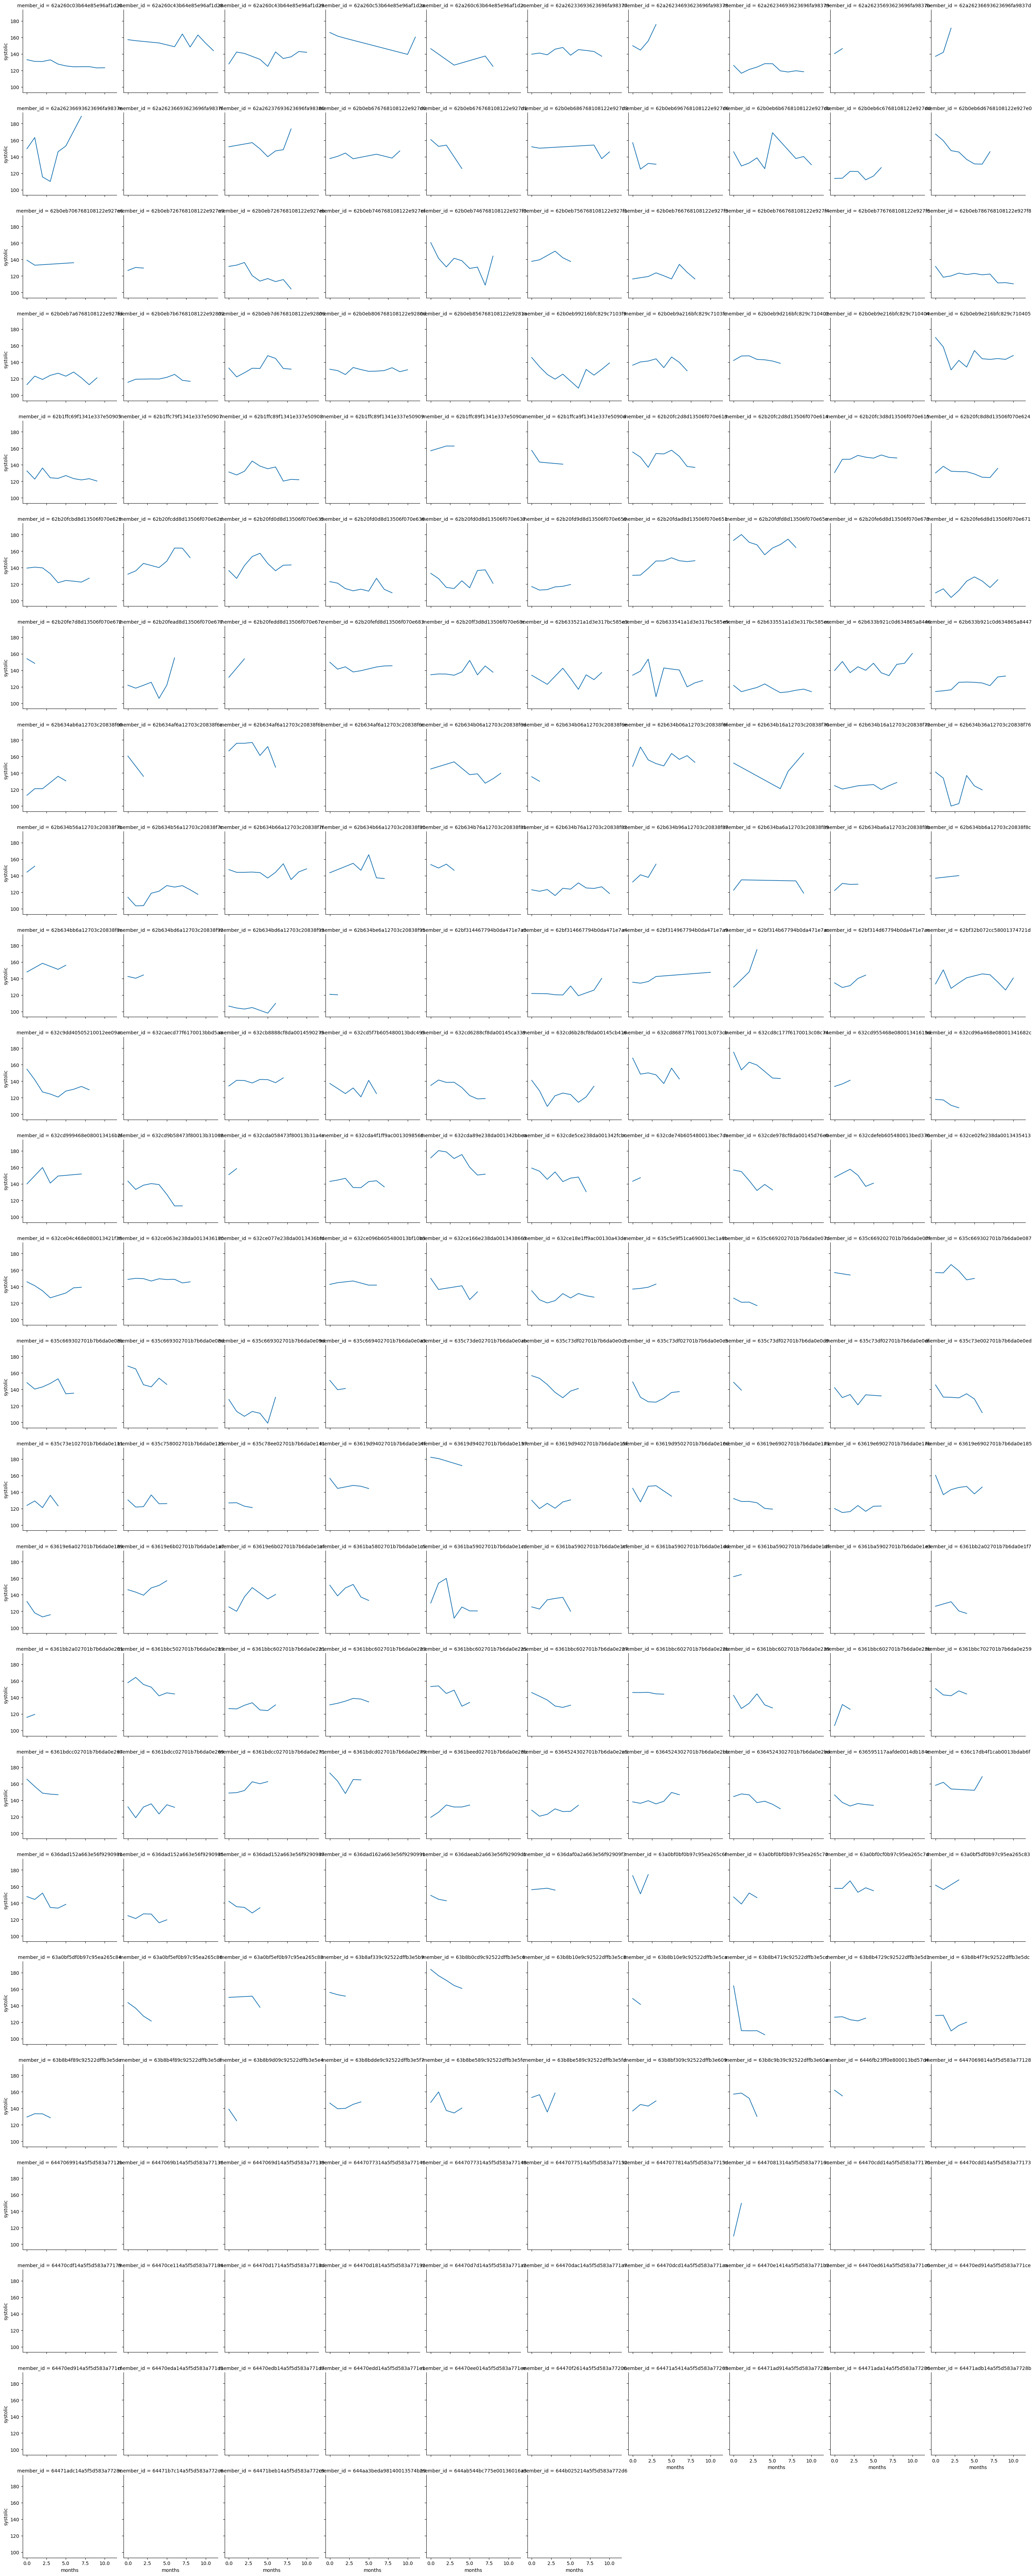

In [21]:
g = sns.FacetGrid(data=sbp, col='member_id', col_wrap=10)
g.map(plt.plot, 'months', 'systolic')
plt.show();

The rather unwieldy plot above shows the time series for each member. We will do further analysis grouped by member and blood pressure factors later on.

## How many months needed for patient from uncontrolled to controlled

In [26]:
# Find first controlled month for each member uncontrolled at baseline
first_controlled = sbp[~sbp.ctrl_bl & sbp.controlled].groupby('member_id')['month'].min().rename('first_controlled')
sbp = sbp.join(first_controlled, on='member_id')
members = members.join(first_controlled, on='member_id')

In [27]:
members.first_controlled.notnull().sum()

56

In [28]:
members['months_to_control'] = np.nan
members.loc[members.first_controlled.notnull(), 'months_to_control'] = members['first_controlled'].dt.to_period('m').astype(int) - members['first_month'].dt.to_period('m').astype(int)

members.head()

,member_id,gender,age_range,first_month,first_controlled,months_to_control
1,62a260c03b64e85e96af1d20,M,45-49,2022-07-01,NaT,NaN
367,62a260c43b64e85e96af1d28,F,60-64,2022-06-01,NaT,NaN
444,62a260c43b64e85e96af1d29,F,50-54,2022-06-01,NaT,NaN
480,62a260c53b64e85e96af1d2a,F,50-54,2022-06-01,2023-04-01,10.0
504,62a260c63b64e85e96af1d2c,M,35-39,2022-07-01,2022-10-01,3.0


In [29]:
members.months_to_control.describe()

count    56.000000
mean      2.696429
std       2.088232
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      10.000000
Name: months_to_control, dtype: float64

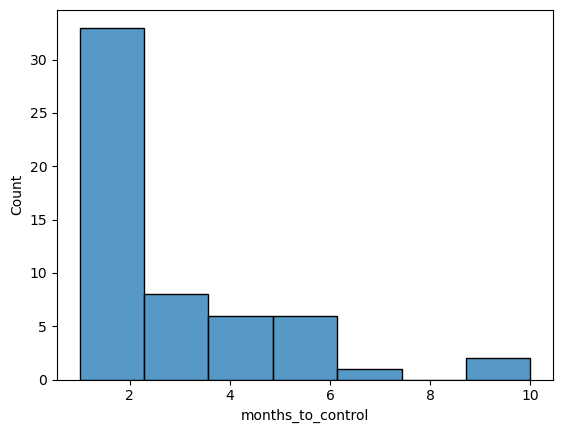

In [30]:
sns.histplot(members.months_to_control);

On average, it takes 2-3 months for members to reach a controlled state, but it can be as long as ten months. Unfortunately, only 56 members reached a controlled state during the program.

## For well controlled patients at baseline, is it well maintained?

In [31]:
sbp.loc[sbp.ctrl_bl, 'controlled'].astype(int).describe()

count    621.000000
mean       0.835749
std        0.370802
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: controlled, dtype: float64

84% of members who start controlled remain controlled for the duration of the data. Although this is a high percentage, this also means that over 15% of patients are entering uncontrolled territory within a year. This strikes me as a high rate of incidence of high blood pressure, so I'd argue that it is not consistently well-maintained by members controlled at baseline. Perhaps they are included in the data because they have risk factors for high blood pressure, which may explain why many of them enter the uncontrolled state.

## For patients from uncontrolled to controlled, is it well maintained or easy to be uncontrolled again?

In [32]:
become_controlled = ~sbp.ctrl_bl & sbp.first_controlled.notnull()

member_mean = sbp.loc[become_controlled & (sbp.month > sbp.first_controlled)].groupby('member_id')['controlled'].mean()
member_mean.describe()

count    49.000000
mean      0.622230
std       0.405111
min       0.000000
25%       0.250000
50%       0.714286
75%       1.000000
max       1.000000
Name: controlled, dtype: float64

In [33]:
members['pct_controlled'] = member_mean

In [34]:
members = members.join((member_mean == 1).rename('maintained'))

In [35]:
(member_mean == 1).mean()

0.4489795918367347

In [36]:
member_mean[member_mean < 1].mean()

0.31441798941798943

In [37]:
sbp['months_since_control'] = np.nan
mask = sbp.first_controlled.notnull() & ~sbp.ctrl_bl
sbp.loc[mask, 'months_since_control'] = sbp.loc[mask].month.dt.to_period('m').astype(int) - sbp.loc[mask].first_controlled.dt.to_period('m').astype(int)

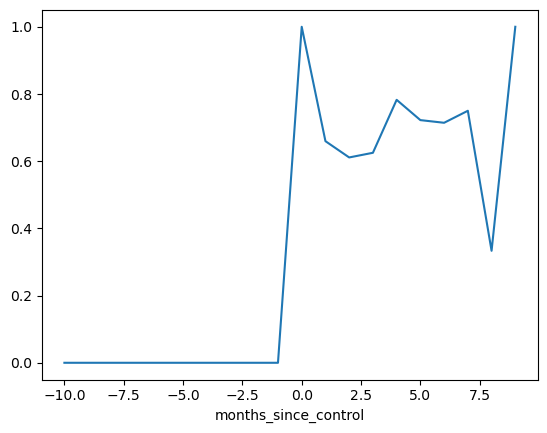

In [38]:
sbp.loc[sbp.first_controlled.notnull()].groupby('months_since_control')['controlled'].mean().plot();

Patients who achieve blood pressure control appear to be somewhat successful at maintaining it, but it is not uncommon for blood pressure to return to being uncontrolled. Although nearly half of members were controlled for the remainder of their time in the program, on average a little under two-thirds of a member's remaining time in the program was controlled. Of members who fell out of control, less than a third of their remaining time in the program was controlled.

This indicates that, although some patients are able to maintain control, those that do not tend to remain mostly uncontrolled for the time in their program. On the assumption that one is trying to build safeguards for patients trying to maintain control, it would make sense to offer special treatment to any patient who falls out of control even once.

## For patients always uncontrolled, what are the vitals patterns?

In [39]:
time_controlled = sbp.groupby('member_id')['controlled'].mean()
always_uncontrolled = time_controlled[time_controlled == 0].index

In [44]:
vitals = ['arrhythmic', 'systolic', 'diastolic', 'heart_rate_bp', 'bg_mmol']
ts.groupby(ts.member_id.isin(always_uncontrolled))[vitals].mean()

,arrhythmic,systolic,diastolic,heart_rate_bp,bg_mmol
member_id,,,,,
False,0.076419,131.772398,78.916969,NaN,8.299992
True,0.085327,154.742690,86.459064,NaN,8.420958


For patients that are always uncontrolled, they tend to have slightly higher instances of arrhythmia and slightly higher blood glucose. Unsurprisingly, they have significantly higher blood pressure, both systolic and diastolic.